# 大作业：使用DDPG解决四轴飞行器悬浮任务

# Step1 安装依赖

# Step2 导入依赖

In [2]:
import os
import numpy as np

import parl
from parl import layers
from paddle import fluid
from parl.utils import logger
from parl.utils import action_mapping # 将神经网络输出映射到对应的 实际动作取值范围 内
from parl.utils import ReplayMemory # 经验回放

from rlschool import make_env  # 使用 RLSchool 创建飞行器环境

# Step3 设置超参数

In [3]:
ACTOR_LR = 0.0002 #0.0002  # Actor网络更新的 learning rate
CRITIC_LR = 0.001 #0.001  # Critic网络更新的 learning rate

GAMMA = 0.99 # 0.99        # reward 的衰减因子，一般取 0.9 到 0.999 不等
TAU = 0.001 # 0.001         # target_model 跟 model 同步参数 的 软更新参数
MEMORY_SIZE = 1e6   # replay memory的大小，越大越占用内存
MEMORY_WARMUP_SIZE = 1e4      # replay_memory 里需要预存一些经验数据，再从里面sample一个batch的经验让agent去learn
REWARD_SCALE = 0.01       # reward 的缩放因子 0.01
BATCH_SIZE = 256          # 每次给agent learn的数据数量，从replay memory随机里sample一批数据出来
TRAIN_TOTAL_STEPS = 1e6   # 总训练步数
TEST_EVERY_STEPS = 1e4    # 每个N步评估一下算法效果，每次评估5个episode求平均reward

# Step4 搭建Model、Algorithm、Agent架构
* `Agent`把产生的数据传给`algorithm`，`algorithm`根据`model`的模型结构计算出`Loss`，使用`SGD`或者其他优化器不断的优化，`PARL`这种架构可以很方便的应用在各类深度强化学习问题中。

## （1）Model
* 分别搭建`Actor`、`Critic`的`Model`结构，构建`QuadrotorModel`。

In [4]:
class ActorModel(parl.Model):
    def __init__(self, act_dim):
        hid_size=100
        self.fc1=layers.fc(size=hid_size, act='relu')
        self.fc2=layers.fc(size=act_dim, act='tanh')

    def policy(self, obs):
        hid=self.fc1(obs)
        logits=self.fc2(hid)
        return logits

In [5]:
class CriticModel(parl.Model):
    def __init__(self):
        hid_size=100
        self.fc1=layers.fc(size=hid_size,act='relu')
        self.fc2=layers.fc(size=1,act=None)

    def value(self, obs, act):
        concat=layers.concat([obs,act],axis=1)
        hid=self.fc1(concat)
        Q=self.fc2(hid)
        Q=layers.squeeze(Q,axes=[1])
        return Q

In [6]:
class QuadrotorModel(parl.Model):
    def __init__(self, act_dim):
        self.actor_model = ActorModel(act_dim)
        self.critic_model = CriticModel()

    def policy(self, obs):
        return self.actor_model.policy(obs)

    def value(self, obs, act):
        return self.critic_model.value(obs, act)

    def get_actor_params(self):
        return self.actor_model.parameters()

## （2）Algorithm
* 可以采用下面的方式从`parl`库中快速引入`DDPG`算法，无需自己重新写算法

In [7]:
from parl.algorithms import DDPG

## （3）Agent

In [8]:
class QuadrotorAgent(parl.Agent):
    def __init__(self, algorithm, obs_dim, act_dim=4):
        assert isinstance(obs_dim, int)
        assert isinstance(act_dim, int)
        self.obs_dim = obs_dim
        self.act_dim = act_dim
        super(QuadrotorAgent, self).__init__(algorithm)

        # 注意，在最开始的时候，先完全同步target_model和model的参数
        self.alg.sync_target(decay=0)

    def build_program(self):
        self.pred_program = fluid.Program()
        self.learn_program = fluid.Program()

        with fluid.program_guard(self.pred_program):
            obs = layers.data(
                name='obs', shape=[self.obs_dim], dtype='float32')
            self.pred_act = self.alg.predict(obs)

        with fluid.program_guard(self.learn_program):
            obs = layers.data(
                name='obs', shape=[self.obs_dim], dtype='float32')
            act = layers.data(
                name='act', shape=[self.act_dim], dtype='float32')
            reward = layers.data(name='reward', shape=[], dtype='float32')
            next_obs = layers.data(
                name='next_obs', shape=[self.obs_dim], dtype='float32')
            terminal = layers.data(name='terminal', shape=[], dtype='bool')
            _, self.critic_cost = self.alg.learn(obs, act, reward, next_obs,
                                                 terminal)

    def predict(self, obs):
        obs = np.expand_dims(obs, axis=0)
        act = self.fluid_executor.run(
            self.pred_program, feed={'obs': obs},
            fetch_list=[self.pred_act])[0]
        return act

    def learn(self, obs, act, reward, next_obs, terminal):
        feed = {
            'obs': obs,
            'act': act,
            'reward': reward,
            'next_obs': next_obs,
            'terminal': terminal
        }
        critic_cost = self.fluid_executor.run(
            self.learn_program, feed=feed, fetch_list=[self.critic_cost])[0]
        self.alg.sync_target()
        return critic_cost


# Step4 Training && Test（训练&&测试）

In [9]:
def run_episode(env, agent, rpm):
    obs = env.reset()
    total_reward, steps = 0, 0
    while True:
        steps += 1
        batch_obs = np.expand_dims(obs, axis=0)
        action = agent.predict(batch_obs.astype('float32'))
        action = np.squeeze(action)

        # 给输出动作增加探索扰动，输出限制在 [-1.0, 1.0] 范围内
        action = np.clip(np.random.normal(action, 1.0), -1.0, 1.0)
        #action=np.random.normal(action, 1.0)
        #act_m=np.mean(action)
        #action=np.clip(0.1*(action-act_m)+act_m,-1.0,1.0)
        # 动作映射到对应的 实际动作取值范围 内, action_mapping是从parl.utils那里import进来的函数
        action_c = action_mapping(action, env.action_space.low[0],
                                env.action_space.high[0])

        next_obs, reward, done, info = env.step(action_c)
        rpm.append(obs, action, REWARD_SCALE * reward, next_obs, done)

        if rpm.size() > MEMORY_WARMUP_SIZE:
            batch_obs, batch_action, batch_reward, batch_next_obs, \
                    batch_terminal = rpm.sample_batch(BATCH_SIZE)
            critic_cost = agent.learn(batch_obs, batch_action, batch_reward,
                                      batch_next_obs, batch_terminal)

        obs = next_obs
        total_reward += reward

        if done:
            break
    return total_reward, steps

# 评估 agent, 跑 5 个episode，总reward求平均
def evaluate(env, agent):
    eval_reward = []
    for i in range(5):
        obs = env.reset()
        total_reward, steps = 0, 0
        while True:
            batch_obs = np.expand_dims(obs, axis=0)
            action = agent.predict(batch_obs.astype('float32'))
            action = np.squeeze(action)
            action=np.clip(action,-1.0,1.0)
            #act_m=np.mean(action)
            #action=np.clip(0.1*(action-act_m)+act_m,-1.0,1.0)
            action_c = action_mapping(action, env.action_space.low[0], 
                                    env.action_space.high[0])

            next_obs, reward, done, info = env.step(action_c)

            obs = next_obs
            total_reward += reward
            steps += 1

            if done:
                break
        eval_reward.append(total_reward)
    return np.mean(eval_reward)

# Step 5 创建环境和Agent，创建经验池，启动训练，定期保存模型

In [10]:
# 创建飞行器环境
env = make_env("Quadrotor", task="hovering_control")
env.reset()
obs_dim = env.observation_space.shape[0]
act_dim = env.action_space.shape[0]

model = QuadrotorModel(act_dim)
algorithm = DDPG(model,gamma=GAMMA,tau=TAU,actor_lr=ACTOR_LR,critic_lr=CRITIC_LR)
agent = QuadrotorAgent(algorithm,obs_dim,act_dim)
print(model.get_actor_params())

# parl库也为DDPG算法内置了ReplayMemory，可直接从 parl.utils 引入使用
rpm = ReplayMemory(int(MEMORY_SIZE), obs_dim, act_dim)

[11-11 05:55:26 MainThread @machine_info.py:88] Cannot find available GPU devices, using CPU now.
[11-11 05:55:26 MainThread @machine_info.py:88] Cannot find available GPU devices, using CPU now.
[11-11 05:55:26 MainThread @machine_info.py:88] Cannot find available GPU devices, using CPU now.
['fc.b_0', 'fc.w_0', 'fc.b_1', 'fc.w_1']


In [11]:
# 启动训练
test_flag = 0
total_steps = 0
# 加载模型
#if os.path.exists('model_dir/steps2_70184.ckpt'):
#     agent.restore('model_dir/steps2_70184.ckpt')
while total_steps < TRAIN_TOTAL_STEPS:
    train_reward, steps = run_episode(env, agent, rpm)
    total_steps += steps
    #logger.info('Steps: {} Reward: {}'.format(total_steps, train_reward)) # 打印训练reward

    if total_steps // TEST_EVERY_STEPS >= test_flag: # 每隔一定step数，评估一次模型
        while total_steps // TEST_EVERY_STEPS >= test_flag:
            test_flag += 1
 
        evaluate_reward = evaluate(env, agent)
        logger.info('Steps {}, Test reward: {}'.format(
            total_steps, evaluate_reward)) # 打印评估的reward

        # 每评估一次，就保存一次模型，以训练的step数命名
        ckpt = 'model_dir/steps1_{}.ckpt'.format(total_steps)
        agent.save(ckpt)

[11-11 05:55:39 MainThread @<ipython-input-11-121f71a64b17>:18] Steps 154, Test reward: -971.6969081731684
[11-11 05:58:08 MainThread @machine_info.py:88] Cannot find available GPU devices, using CPU now.
[11-11 05:58:19 MainThread @<ipython-input-11-121f71a64b17>:18] Steps 10010, Test reward: -653.6626431189692
[11-11 06:04:44 MainThread @<ipython-input-11-121f71a64b17>:18] Steps 20240, Test reward: -764.6431614232498
[11-11 06:11:16 MainThread @<ipython-input-11-121f71a64b17>:18] Steps 30097, Test reward: -4753.200002964781
[11-11 06:17:47 MainThread @<ipython-input-11-121f71a64b17>:18] Steps 40002, Test reward: -2821.4174107424938
[11-11 06:24:33 MainThread @<ipython-input-11-121f71a64b17>:18] Steps 50211, Test reward: -1099.677458459299
[11-11 06:31:56 MainThread @<ipython-input-11-121f71a64b17>:18] Steps 60624, Test reward: -7061.845061537026
[11-11 06:39:36 MainThread @<ipython-input-11-121f71a64b17>:18] Steps 70909, Test reward: -2074.933926425364
[11-11 06:46:45 MainThread @<ip

KeyboardInterrupt: ignored

In [14]:
#上面运行结果：
with open('steps1.txt') as f:
    rsts=f.readlines()
f.close()
steps=[]
rewards=[]
rsts=rsts[2:]
#itm=rsts[2]
for itm in rsts:
    p1=itm.find('Steps')
    p2=itm.find(',')
    p3=itm.rfind(':')
    steps.append(int(itm[p1+6:p2]))
    rewards.append(float(itm[p3+1:-1]))


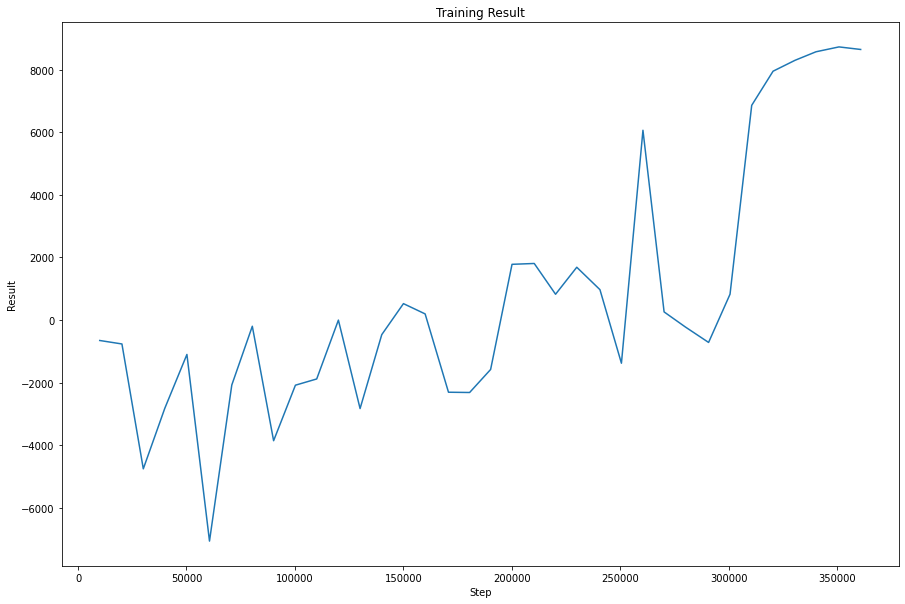

In [15]:
import matplotlib.pyplot as plt
%matplotlib inline
f=plt.figure(figsize=(15,10))
plt.plot(steps, rewards)
plt.title('Training Result')
plt.xlabel('Step')
plt.ylabel('Result')
plt.show()

# 验收测评

In [19]:
ckpt = './model_dir/steps1_360922.ckpt'  # 请设置ckpt为你训练中效果最好的一次评估保存的模型文件名称

agent.restore(ckpt)
evaluate_reward = evaluate(env, agent)
logger.info('Evaluate reward: {}'.format(evaluate_reward)) # 打印评估的reward

[11-11 10:21:23 MainThread @<ipython-input-19-9cbdd7c6fe72>:5] Evaluate reward: 8596.243893483133
